In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23


<BarContainer object of 2230 artists>

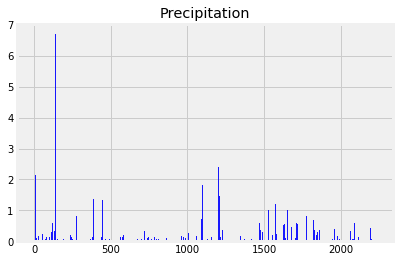

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime as dt

session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# last date estblished as 8-23-2017

yr_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(yr_ago)
# 1 yr ago date established as 8-23-2016

# Perform a query to retrieve the data and precipitation scores
precip_data  = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').order_by(Measurement.date).all()
#print(precip_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
#precip_df.head()

# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values(by = 'date')
#precip_df_sorted.head()

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(precip_df_sorted))
plt.title("Precipitation")
plt.bar(x_axis, precip_df_sorted["prcp"], color='b', alpha=0.9, align="center")
#plt.savefig(../Images/Precipitation.png)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
#session.query(Measurement.station).distinct().all()
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

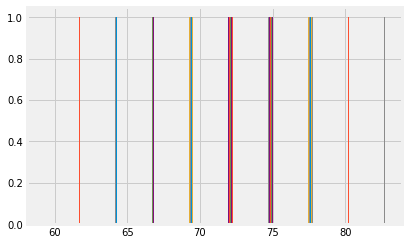

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-8-22').\
    order_by(Measurement.tobs).all()
#print(temps)
plt.hist(temps)
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2017-01-01', '2017-01-11'))
trip = (calc_temps('2017-01-01', '2017-01-11'))
print(trip)

[(60.0, 68.14925373134328, 78.0)]
[(60.0, 68.14925373134328, 78.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

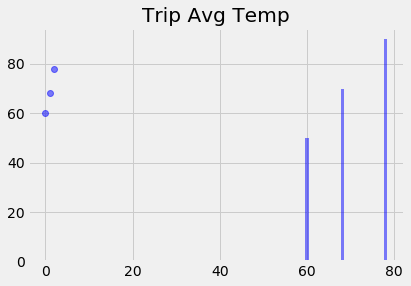

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
from scipy.stats import sem
x_axis = [60.0, 68.149, 78.0]
avg_temp = [50,70,90]
std_err = [sem(s) for s in x_axis]
fig, ax = plt.subplots()
ax.errorbar(np.arange(0, len(avg_temp)), x_axis, yerr = std_err, fmt="o", color = 'b', alpha=0.5)
plt.bar(x_axis, avg_temp, color = 'b', alpha=0.5, align="center")
plt.title("Trip Avg Temp")

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
from sqlalchemy import and_

joined = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.station, Measurement.prcp, Measurement.date]
vac_query = session.query(*joined).filter(Station.station == Measurement.station)

print(vac_query)
#session.query(Measurement.station,  func.sum(Measurement.prcp)).\
             #filter((Measurement.date < 2017-1-1)).\
             #group_by(Measurement.station).all()


SELECT station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, measurement.station AS measurement_station, measurement.prcp AS measurement_prcp, measurement.date AS measurement_date 
FROM station, measurement 
WHERE station.station = measurement.station


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
